# Speech-to-Text Interface for Physiotherapists

**ROMTech**

Manoj Sharma, Omid Moridnejad, Raquel Colares, Thuvaarakkesh Ramanathan

## Installations

In [1]:
# Installing the necessary libraries
!pip install whisper
!pip install --upgrade --no-cache-dir git+https://github.com/openai/whisper.git
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=269e1f51d8a07556a83346cca728f11ab3e1ce01bb7ce4097d253cdde1287ace
  Stored in directory: /root/.cache/pip/wheels/21/65/ee/4e6672aabfa486d3341a39a04f8f87c77e5156149299b5a7d0
Successfully built whisper
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-ach9u9dw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-ach9u9dw
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 224.2 MB/s eta 0:00:00

## Libraries

In [2]:
# Importing the libraries
import whisper
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import requests
import tempfile
import shutil

## Data

In [3]:
# Getting the audios data from the Github repository
def get_github_audio_files():
    url = "https://api.github.com/repos/raquelcolares/ROMTech/contents/data"
    response = requests.get(url)
    data = response.json()
    audio_urls = [item["download_url"] for item in data if item["name"].endswith(".wav") or item["name"].endswith(".mp3")]
    return audio_urls

def download_and_transcribe(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            shutil.copyfileobj(response.raw, tmp)
            return transcribe_audio(tmp.name)
    return None

def transcribe_all_from_github():
    audio_urls = get_github_audio_files()
    transcriptions = []
    for url in audio_urls:
        print(f"Transcribing: {url}")
        text = download_and_transcribe(url)
        if text:
            transcriptions.append(text)
    return transcriptions

## Transcription

### Whisper model

In [4]:
# Loading and defining the Whisper and Sentece Transformer model
def load_whisper_model():
    return whisper.load_model("base")

def load_sentence_model():
    return SentenceTransformer("all-MiniLM-L6-v2")

whisper_model = load_whisper_model()
sentence_model = load_sentence_model()

100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 49.4MiB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
# Transcribing the audios using the Whisper model
def transcribe_audio(audio_path):
    result = whisper_model.transcribe(audio_path)
    return result["text"]

## Summarization

### Autoencoder model

In [6]:
# Creating the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# Training the Autoencoder on the transcriptions got it from Whisper
def train_autoencoder(transcriptions, num_epochs, criterion, optimizer, autoencoder):
    all_embeddings = []
    for transcription in transcriptions:
        sentences = transcription.split(". ")
        if len(sentences) < 2:
            continue
        embeddings = sentence_model.encode(sentences, normalize_embeddings=True)
        all_embeddings.append(torch.tensor(embeddings, dtype=torch.float32))

    num_epochs = num_epochs
    losses = []
    cosine_scores = []

    for epoch in range(num_epochs):
        total_loss = 0
        total_cosine = 0
        total_sentences = 0

        for embeddings in all_embeddings:
            outputs = autoencoder(embeddings)
            loss = criterion(outputs, embeddings)

            mse = criterion(outputs, embeddings)
            cosine = 1 - F.cosine_similarity(outputs, embeddings, dim=1).mean()
            loss = mse + cosine

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_cosine += (1 - cosine.item()) * len(embeddings)
            total_sentences += len(embeddings)

        avg_loss = total_loss / len(all_embeddings)
        avg_cosine = total_cosine / total_sentences
        losses.append(avg_loss)
        cosine_scores.append(avg_cosine)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Cosine Similarity: {avg_cosine:.4f}")

    # Plotting the Loss Curve and Cosine Similarity
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), losses, label="MSE Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), cosine_scores, label="Cosine Similarity", color="green")
    plt.title("Cosine Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Cosine Similarity")
    plt.show()

    # Saving the autoencoder model weights
    torch.save(autoencoder.state_dict(), "autoencoder.pt")
    print("Autoencoder model saved as 'autoencoder.pt'.")

    return autoencoder

In [8]:
# Summarizing the transcriptions
def summarize_text(transcription, autoencoder):
    sentences = transcription.split(". ")
    if len(sentences) <= 2:
        return transcription

    embeddings = sentence_model.encode(sentences)
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

    with torch.no_grad():
        encoded = autoencoder.encoder(embeddings_tensor)
        decoded = autoencoder.decoder(encoded)
        errors = torch.mean((decoded - embeddings_tensor) ** 2, dim=1)
        summary_length = min(10, len(sentences))
        top_indices = errors.argsort()[:summary_length]
        summary = " ".join([sentences[i] for i in sorted(top_indices)])

    return summary


------ Transcribing the audio files of Github ------
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation01_doctor.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation01_patient.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation02_doctor.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation02_patient.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation03_doctor.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation03_patient.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation04_doctor.wav
Transcribing: https://raw.githubusercontent.com/raquelcolares/ROMTech/main/data/day1_consultation04_patient.wav
Transcribing: https://raw.githubusercontent.com/raquel

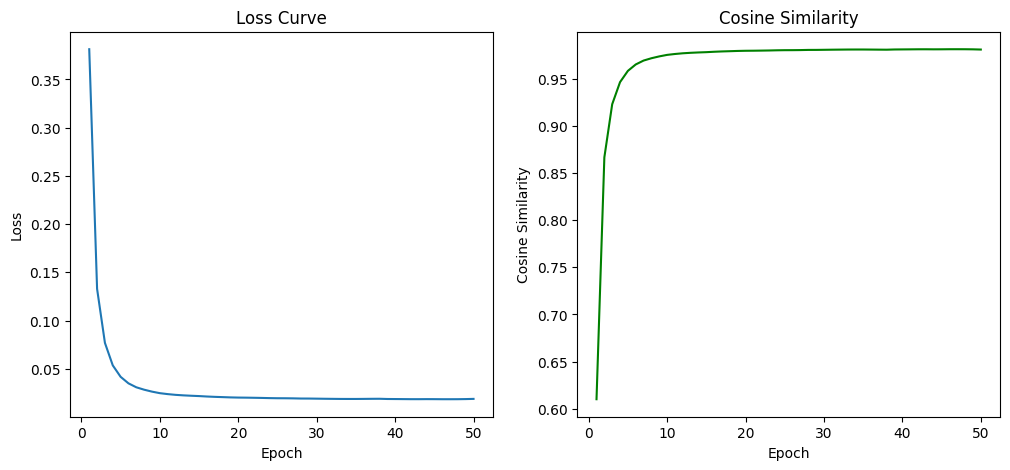

Autoencoder model saved as 'autoencoder.pt'.

----- Transcription and Summaries ------

Transcript (1):  Hello. Hi. Shall we just stop? Yeah. Okay. Hello. The morning's a hug. I'll help you this morning. Sorry to hear that. And when you say diuret, what do you mean by diuret? I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. I'm sorry. You need that. I'm sorry. What do I mean by diuret? What do you mean by diuret? Do you mean you gain to this toilet more often, or are your stools more loose? You. Right. Okay. And how many times a day are you going? Let's say, we'll last a couple of days. Just some times a day. And your mentions in the main, we have, you know, seen any other things like blood in your stools? Right. Okay, and you mentioned you've had some pain in your tummy as well. Where about is the pain? Is that clear? One side,

In [9]:
# Main function for the transcription and summarization process
def main():
    print("\n------ Transcribing the audio files of Github ------")
    transcriptions = transcribe_all_from_github()

    print("\n------ Training the Autoencoder Summarization model ------")
    autoencoder = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    num_epochs = 50
    autoencoder = train_autoencoder(transcriptions, num_epochs, criterion, optimizer, autoencoder)

    print("\n----- Transcription and Summaries ------")
    # Printing a few transcriptions and summaries for analysis
    for i, transcription in enumerate(transcriptions[:5]):
        summary = summarize_text(transcription, autoencoder)
        print(f"\nTranscript ({i+1}): {transcription}")
        print(f"Summary ({i+1}): {summary}")

if __name__ == "__main__":
    main()

### BERT model

## References


Korfiatis A.P, Sarac R., Moramarco F., Savkov A. (2022). *PriMock57: A Dataset Of Primary Care Mock Consultations.* Available at: https://arxiv.org/abs/2204.00333 (Accessed: February 2025)

*Sequence Modeling With CTC* Available at: https://distill.pub/2017/ctc/ (Accessed: February 2025)

Platen, P.V. *Fine-Tune Wav2Vec2 for English ASR with Transformers* Available at: https://huggingface.co/blog/fine-tune-wav2vec2-english (Accessed: February 2025)

OpenAI Platform. *Speech to text.* Available at: https://platform.openai.com/docs/guides/speech-to-text (Accessed: February 2025)

PyTorch. *Cosine Similarity.* Available at: https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html (Accessed: April 2025)